# stl10-embedding dataset 

In [1]:
# Imports
import os
import sys
BASE_DIR = os.path.dirname(os.getcwd())
sys.path.append(BASE_DIR)
import torch
import numpy as np
import pandas as pd

# Opendataval
from dataval.dataloader import Register, DataFetcher, mix_labels, add_gauss_noise
from dataval.datavaluation import NDDV, NDSV
from dataval.experiment import ExperimentMediator

import warnings
warnings.filterwarnings("ignore")

[KeOps] Warning : 
    The default C++ compiler could not be found on your system.
    You need to either define the CXX environment variable or a symlink to the g++ command.
    For example if g++-8 is the command you can do
      import os
      os.environ['CXX'] = 'g++-8'
    
[KeOps] Warning : Cuda libraries were not detected on the system ; using cpu only mode


In [2]:
DataFetcher.datasets_available()

{'2dplanes',
 'MiniBooNE',
 'adult',
 'bbc',
 'bbc-embeddings',
 'breast_cancer',
 'challenge-iris',
 'cifar10',
 'cifar10-embeddings',
 'cifar100',
 'cifar100-embeddings',
 'creditcard',
 'diabetes',
 'digits',
 'echoMonths',
 'election',
 'electricity',
 'fashion',
 'fmnist-embeddings',
 'fried',
 'gaussian_classifier',
 'gaussian_classifier_high_dim',
 'imdb',
 'imdb-embeddings',
 'iris',
 'linnerud',
 'lowbwt',
 'mnist',
 'mnist-embeddings',
 'mv',
 'nomao',
 'pol',
 'stl10-embeddings',
 'stock',
 'svhn-embeddings',
 'vehicle_sensIT',
 'wave_energy',
 'webdata_wXa'}

## [Step 1] Set up an environment
`ExperimentMediator` is a fundamental concept in establishing the `opendataval` environment. It empowers users to configure hyperparameters, including a dataset, a type of synthetic noise, and a prediction model. With  `ExperimentMediator`, users can effortlessly compute various data valuation algorithms.

The following code cell demonstrates how to set up `ExperimentMediator` with a pre-registered dataset and a prediction model.
- Dataset: adult
- Model: sklearn's logistic regression model
- Metric: Classification accuracy

In [3]:
dataset_name = "stl10-embeddings"
train_count, valid_count, test_count, meta_count = 1000, 100, 300, 100
# train_count, valid_count, test_count, meta_count = 0.7, 0.05, 0.2, 0.05
noise_rate = 0.05
noise_kwargs = {'noise_rate': noise_rate}
max_epoch = 3
batch_size = 100
lr = 0.01
random_state = 42
train_kwargs = {"epochs": max_epoch, "batch_size": batch_size, "lr": lr}
# model_name = "classifiermlp"   # "sklogreg"
model_name = "LogisticRegression"
metric_name = "accuracy"
cache_dir = "../data_files/"
add_noise = add_gauss_noise
noise_type = "gauss_noise"
device = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'

exper_med = ExperimentMediator.model_factory_setup(
    dataset_name=dataset_name,
    cache_dir=cache_dir,  
    force_download=False,
    train_count=train_count,
    valid_count=valid_count,
    test_count=test_count,
    meta_count=meta_count,
    add_noise=add_noise, 
    noise_kwargs=noise_kwargs,
    train_kwargs=train_kwargs,
    random_state = random_state,
    model_name=model_name,
    metric_name=metric_name,
    device=device
)

40it [04:19,  6.50s/it]


Base line model metric_name='accuracy': perf=0.9333333373069763


A full list of registered datasets can be found [here](https://github.com/opendataval/opendataval/blob/main/opendataval/dataloader/fetcher.py#L121). A list of available  prediction models can be found [here](https://github.com/opendataval/opendataval/blob/main/opendataval/model/__init__.py#L111).

## [Step 2] Compute data values
`opendataval` provides various state-of-the-art data valuation algorithms. `ExperimentMediator.compute_data_values()` computes data values.

In [4]:
data_evaluators = [NDSV(mfg_epochs=50, base_model=model_name, meta_interval=5, Ntime=1, batch_size=batch_size, weight_decay=5e-4, meta_weight_decay=0, meta_hidden_size=10)]

In [5]:
%%time
# compute data values.
exper_med = exper_med.compute_data_values(data_evaluators=data_evaluators)

  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [00:10<00:00,  4.62it/s]

Elapsed time NDSV(mfg_epochs=50, base_model=LogisticRegression, meta_interval=5, Ntime=1, batch_size=100, weight_decay=0.0005, meta_weight_decay=0, meta_hidden_size=10): 0:00:10.852973
CPU times: total: 1min 8s
Wall time: 10.9 s


## [Step 3] Evaluate data values

In [6]:
from dataval.experiment.exper_methods import (
    discover_corrupted_sample,
    noisy_detection,
    remove_high_low,
    remove_high_value,
    remove_low_value,
    add_low_high,
    add_high_value,
    add_low_value,
    save_dataval
)
from matplotlib import pyplot as plt

In [7]:
# Saving the results with percent 5%
percent = 0.05
output_dir = f"../results/NDDV_{device}_{dataset_name}_{model_name}_{noise_type}_{noise_rate=}_{train_count=}_{percent=}/"
exper_med.set_output_directory(output_dir)
output_dir

'../results/NDDV_cpu_stl10-embeddings_LogisticRegression_gauss_noise_noise_rate=0.05_train_count=1000_percent=0.05/'

### Noisy data detection 
- `noisy_detection` performs the noisy data detection task and evaluates the F1-score of each data valuation algorithm's prediction. The higher, the better.  
  - noisy data: mislabeled data

In [8]:
exper_med.evaluate(noisy_detection, save_output=True)

,kmeans_f1
"NDSV(mfg_epochs=50, base_model=LogisticRegression, meta_interval=5, Ntime=1, batch_size=100, weight_decay=0.0005, meta_weight_decay=0, meta_hidden_size=10)",0.326797


### Discover noisy samples
- `discover_corrupted_sample` visualizes how well noisy data points are identified when a fraction of dataset is inspected. 

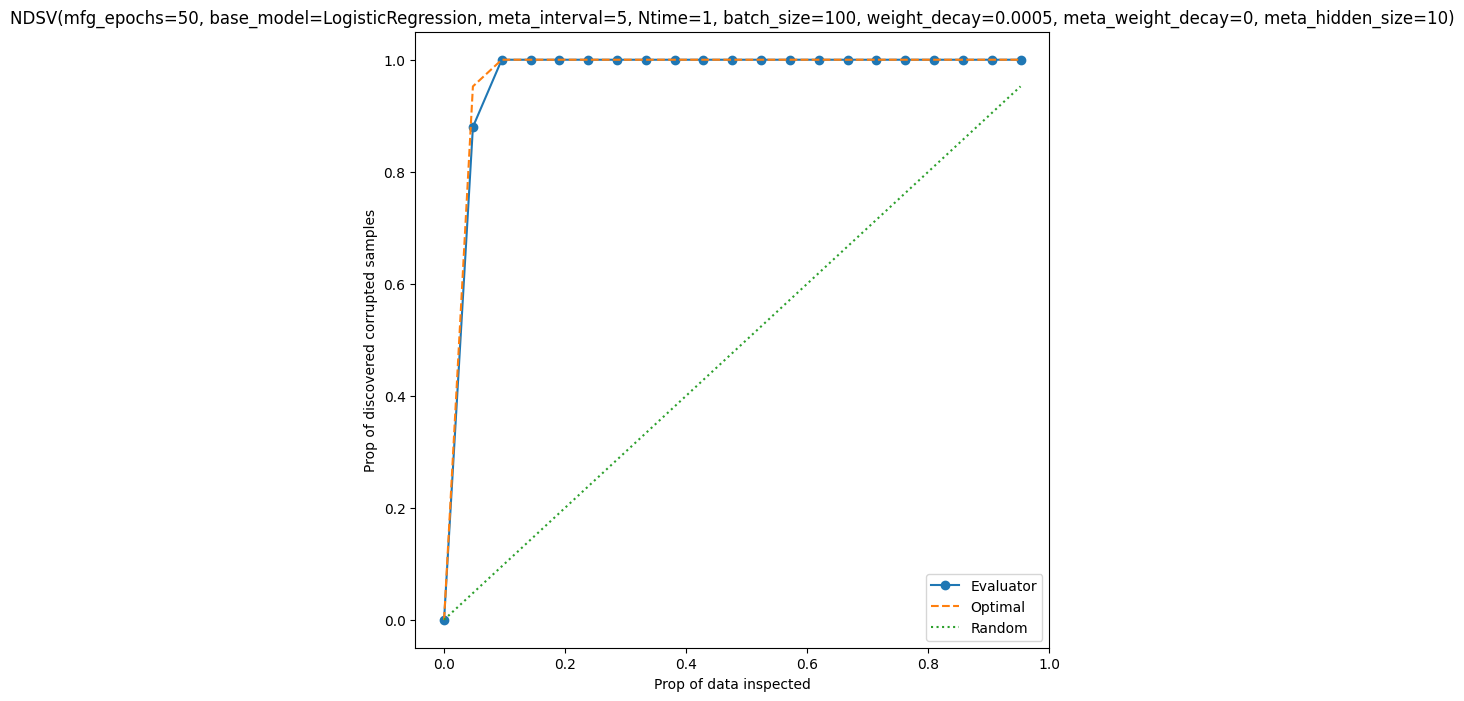

In [9]:
fig = plt.figure(figsize=(18, 8))
df, fig = exper_med.plot(discover_corrupted_sample, fig, col=2, percnet=percent, save_output=True)

### Point removal experiment
- `remove_high_low` performs the point removal experiment. Each data valution algorithm, it provides two curves: one is removing data in a descending order (orange), the other is in an ascending order (blue). As for the orange (resp. blue) curve, the lower (resp. upper), the better. 

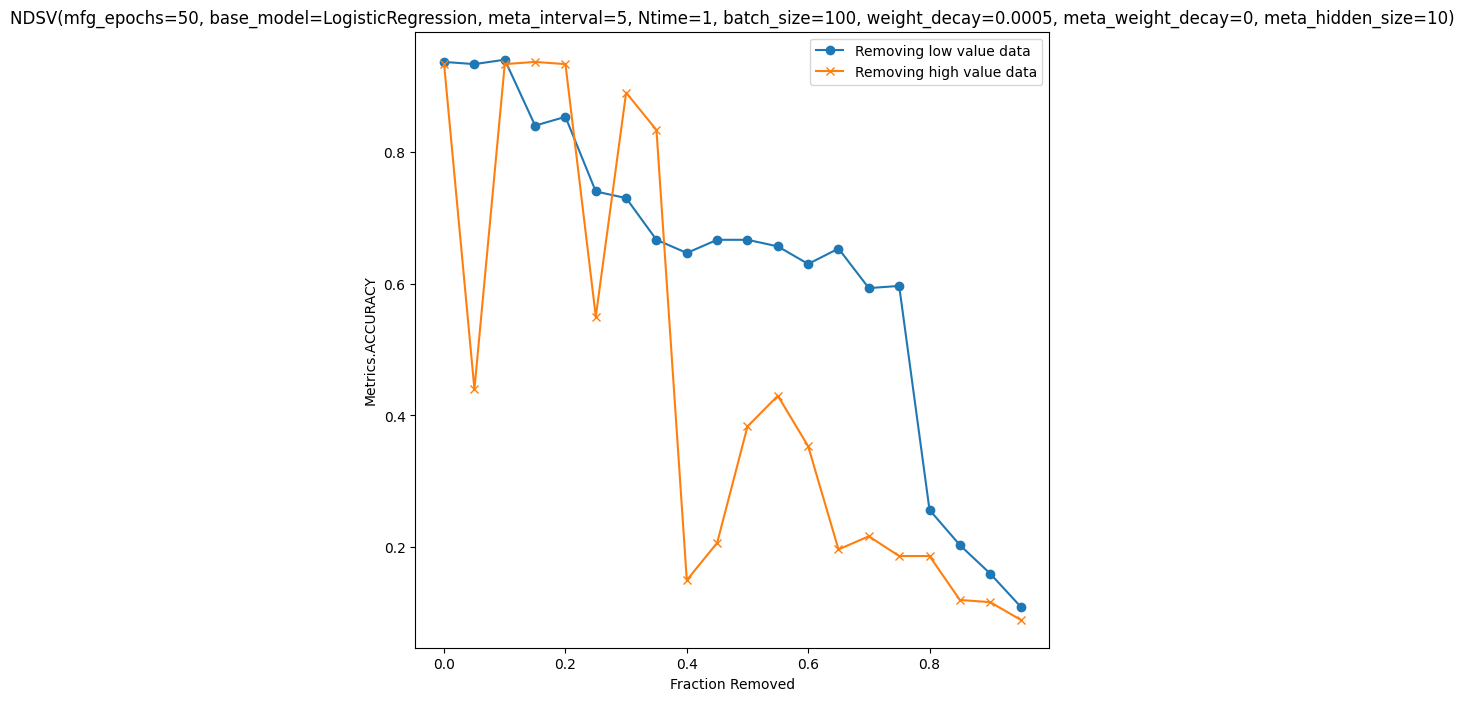

In [10]:
fig = plt.figure(figsize=(18, 8))
df_resp, fig = exper_med.plot(remove_high_low, fig, col=2, percnet=percent, save_output=True)

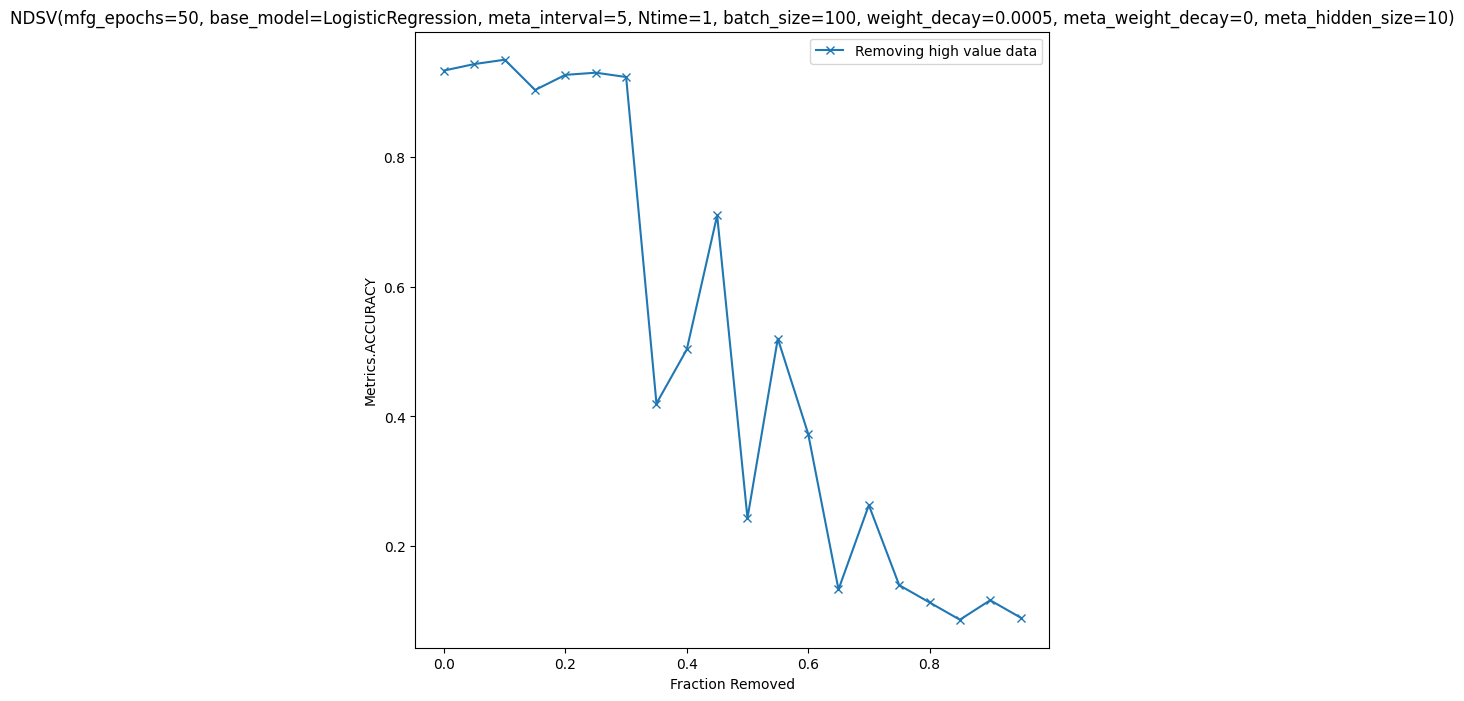

In [11]:
fig = plt.figure(figsize=(18, 8))
df, fig = exper_med.plot(remove_high_value, fig, col=2, percnet=percent, save_output=True)

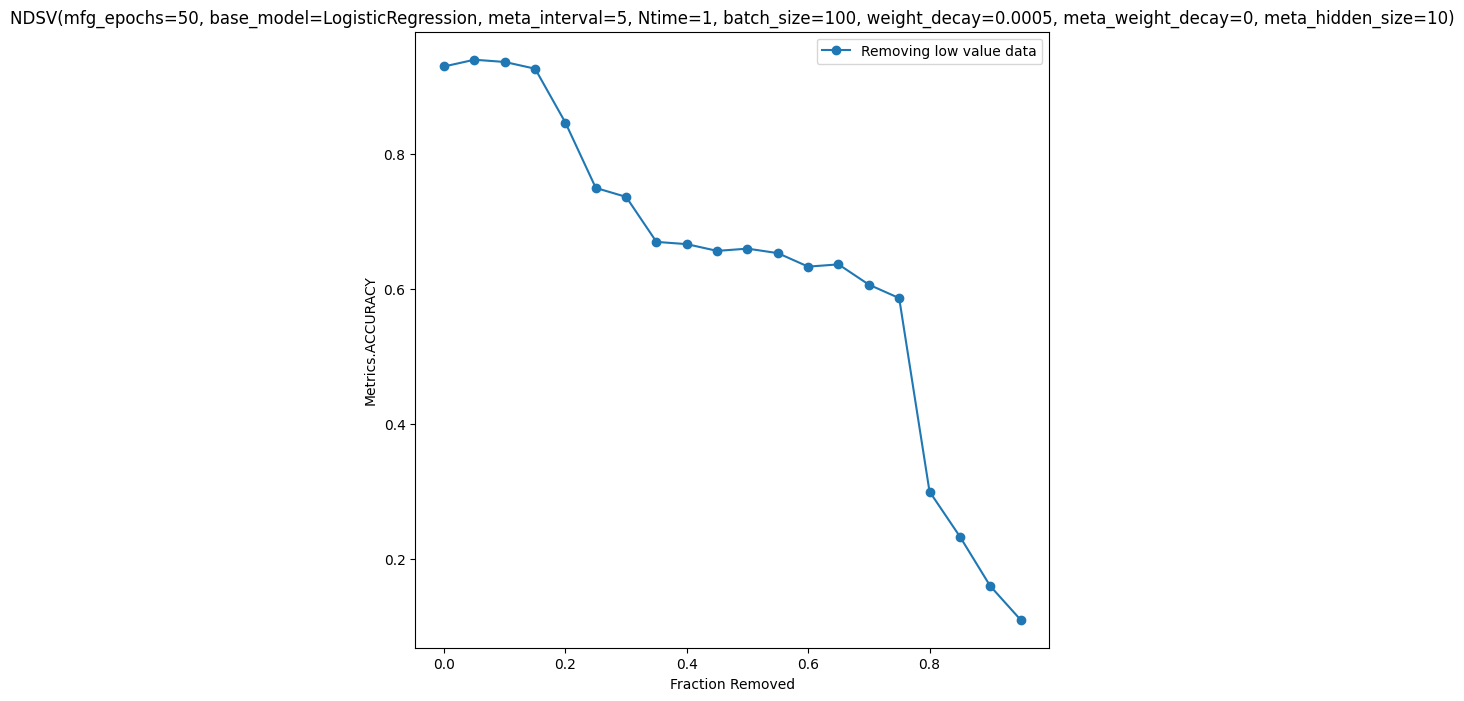

In [12]:
fig = plt.figure(figsize=(18, 8))
df, fig = exper_med.plot(remove_low_value, fig, col=2, percnet=percent, save_output=True)

In [13]:
df_resp # it provides complete information for generating point-removal experiment figures.

,remove_least_influential_first_Metrics.ACCURACY,remove_most_influential_first_Metrics.ACCURACY,axis
"NDSV(mfg_epochs=50, base_model=LogisticRegression, meta_interval=5, Ntime=1, batch_size=100, weight_decay=0.0005, meta_weight_decay=0, meta_hidden_size=10)",0.936667,0.933333,0.0
"NDSV(mfg_epochs=50, base_model=LogisticRegression, meta_interval=5, Ntime=1, batch_size=100, weight_decay=0.0005, meta_weight_decay=0, meta_hidden_size=10)",0.933333,0.44,0.05
"NDSV(mfg_epochs=50, base_model=LogisticRegression, meta_interval=5, Ntime=1, batch_size=100, weight_decay=0.0005, meta_weight_decay=0, meta_hidden_size=10)",0.94,0.933333,0.1
"NDSV(mfg_epochs=50, base_model=LogisticRegression, meta_interval=5, Ntime=1, batch_size=100, weight_decay=0.0005, meta_weight_decay=0, meta_hidden_size=10)",0.84,0.936667,0.15
"NDSV(mfg_epochs=50, base_model=LogisticRegression, meta_interval=5, Ntime=1, batch_size=100, weight_decay=0.0005, meta_weight_decay=0, meta_hidden_size=10)",0.853333,0.933333,0.2
"NDSV(mfg_epochs=50, base_model=LogisticRegression, meta_interval=5, Ntime=1, batch_size=100, weight_decay=0.0005, meta_weight_decay=0, meta_hidden_size=10)",0.74,0.55,0.25
"NDSV(mfg_epochs=50, base_model=LogisticRegression, meta_interval=5, Ntime=1, batch_size=100, weight_decay=0.0005, meta_weight_decay=0, meta_hidden_size=10)",0.73,0.89,0.3
"NDSV(mfg_epochs=50, base_model=LogisticRegression, meta_interval=5, Ntime=1, batch_size=100, weight_decay=0.0005, meta_weight_decay=0, meta_hidden_size=10)",0.666667,0.833333,0.35
"NDSV(mfg_epochs=50, base_model=LogisticRegression, meta_interval=5, Ntime=1, batch_size=100, weight_decay=0.0005, meta_weight_decay=0, meta_hidden_size=10)",0.646667,0.15,0.4
"NDSV(mfg_epochs=50, base_model=LogisticRegression, meta_interval=5, Ntime=1, batch_size=100, weight_decay=0.0005, meta_weight_decay=0, meta_hidden_size=10)",0.666667,0.206667,0.45


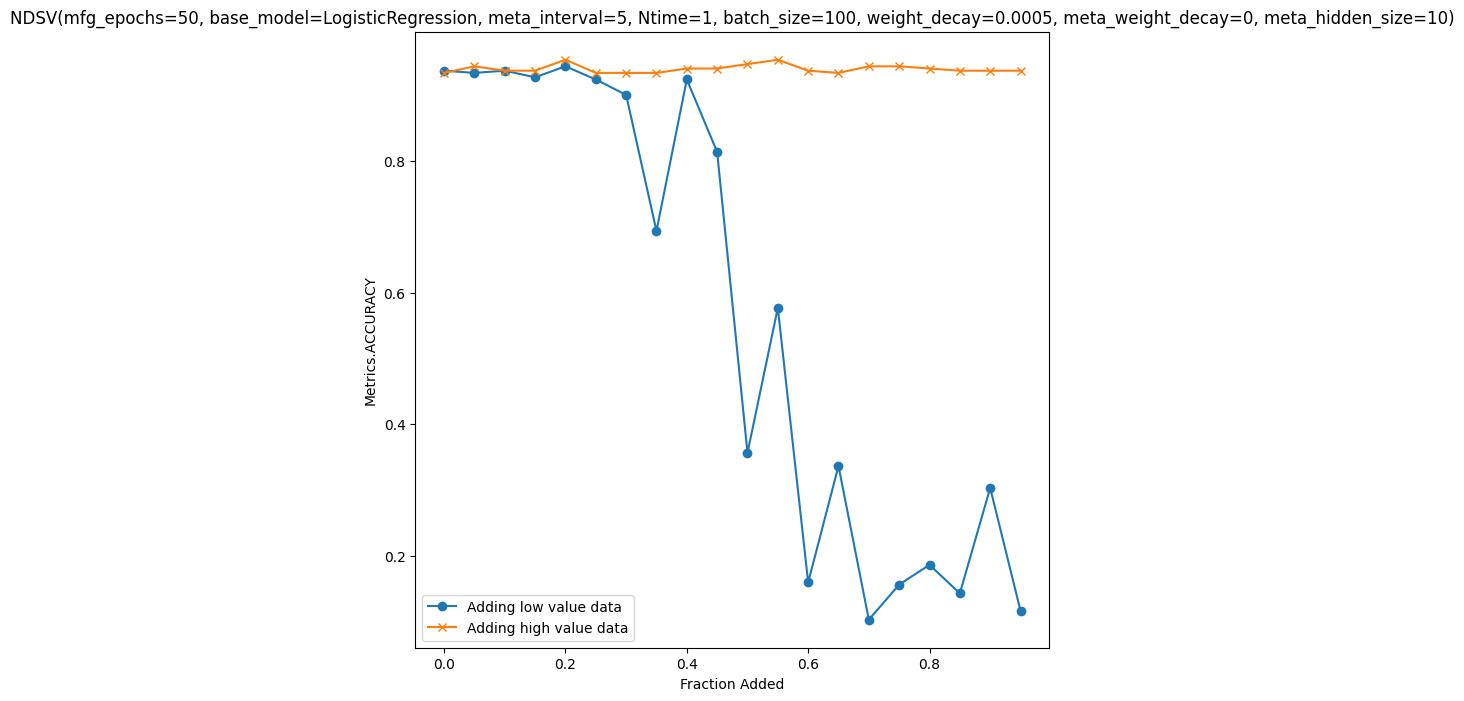

In [14]:
fig = plt.figure(figsize=(18, 8))
df_addp, fig = exper_med.plot(add_low_high, fig, col=2, percnet=percent, save_output=True)

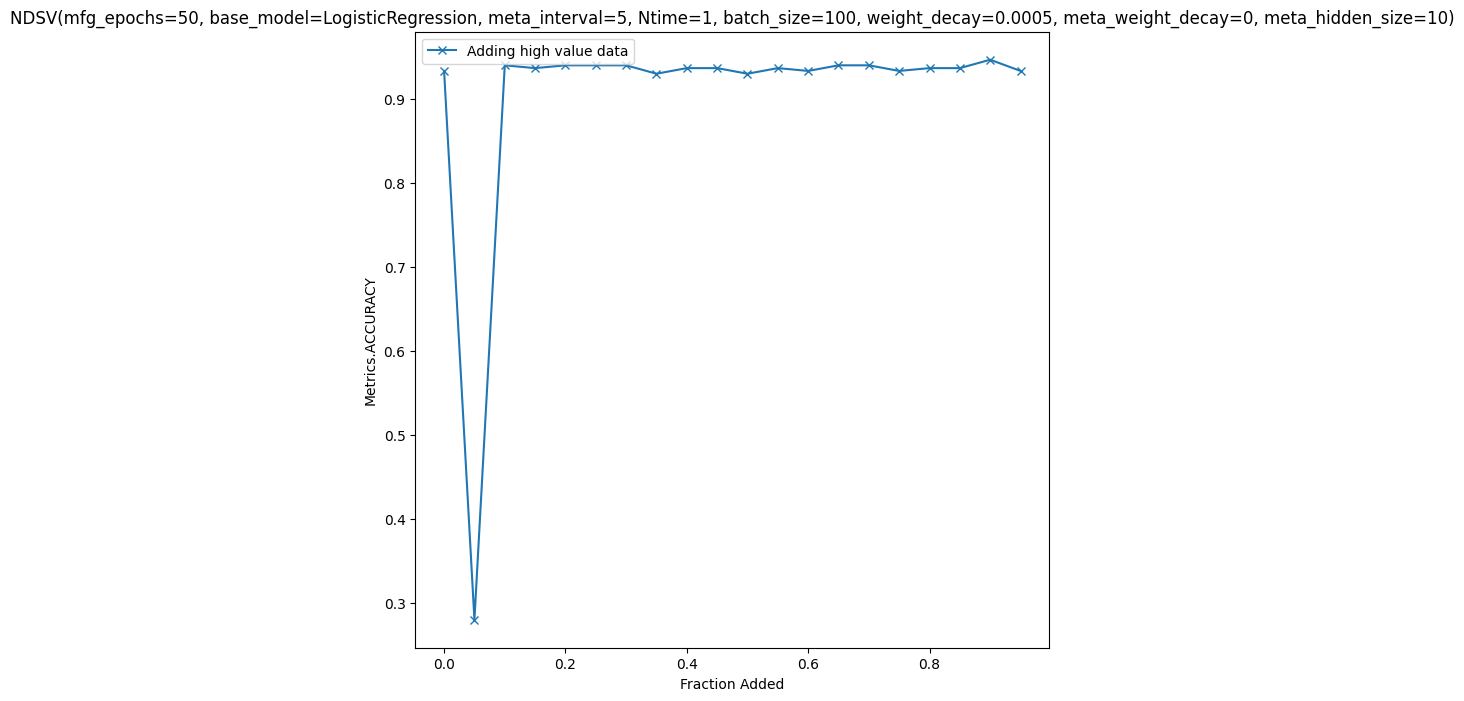

In [15]:
fig = plt.figure(figsize=(18, 8))
df, fig = exper_med.plot(add_high_value, fig, col=2, percnet=percent, save_output=True)

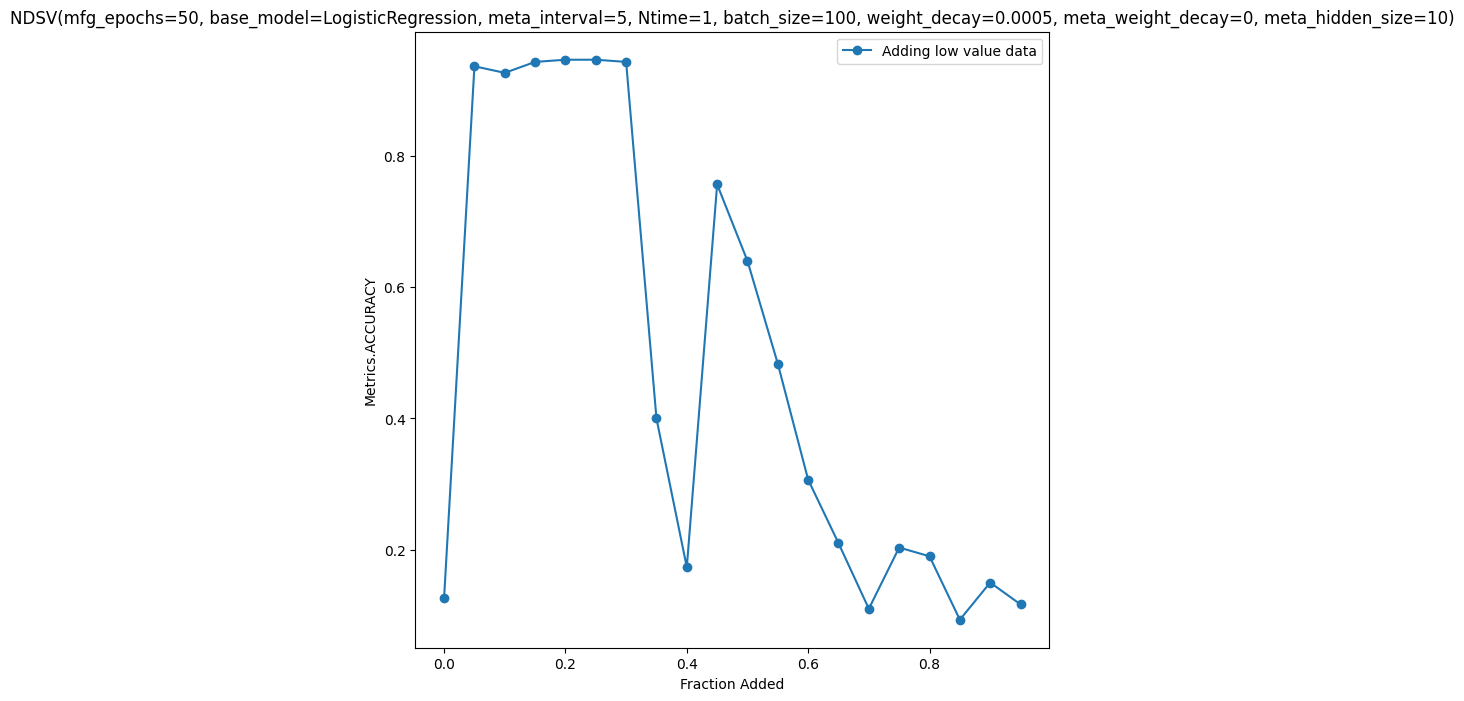

In [16]:
fig = plt.figure(figsize=(18, 8))
df, fig = exper_med.plot(add_low_value, fig, col=2, percnet=percent, save_output=True)

In [17]:
df_addp

,add_least_influential_first_Metrics.ACCURACY,add_most_influential_first_Metrics.ACCURACY,axis
"NDSV(mfg_epochs=50, base_model=LogisticRegression, meta_interval=5, Ntime=1, batch_size=100, weight_decay=0.0005, meta_weight_decay=0, meta_hidden_size=10)",0.116667,0.936667,0.95
"NDSV(mfg_epochs=50, base_model=LogisticRegression, meta_interval=5, Ntime=1, batch_size=100, weight_decay=0.0005, meta_weight_decay=0, meta_hidden_size=10)",0.303333,0.936667,0.9
"NDSV(mfg_epochs=50, base_model=LogisticRegression, meta_interval=5, Ntime=1, batch_size=100, weight_decay=0.0005, meta_weight_decay=0, meta_hidden_size=10)",0.143333,0.936667,0.85
"NDSV(mfg_epochs=50, base_model=LogisticRegression, meta_interval=5, Ntime=1, batch_size=100, weight_decay=0.0005, meta_weight_decay=0, meta_hidden_size=10)",0.186667,0.94,0.8
"NDSV(mfg_epochs=50, base_model=LogisticRegression, meta_interval=5, Ntime=1, batch_size=100, weight_decay=0.0005, meta_weight_decay=0, meta_hidden_size=10)",0.156667,0.943333,0.75
"NDSV(mfg_epochs=50, base_model=LogisticRegression, meta_interval=5, Ntime=1, batch_size=100, weight_decay=0.0005, meta_weight_decay=0, meta_hidden_size=10)",0.103333,0.943333,0.7
"NDSV(mfg_epochs=50, base_model=LogisticRegression, meta_interval=5, Ntime=1, batch_size=100, weight_decay=0.0005, meta_weight_decay=0, meta_hidden_size=10)",0.336667,0.933333,0.65
"NDSV(mfg_epochs=50, base_model=LogisticRegression, meta_interval=5, Ntime=1, batch_size=100, weight_decay=0.0005, meta_weight_decay=0, meta_hidden_size=10)",0.16,0.936667,0.6
"NDSV(mfg_epochs=50, base_model=LogisticRegression, meta_interval=5, Ntime=1, batch_size=100, weight_decay=0.0005, meta_weight_decay=0, meta_hidden_size=10)",0.576667,0.953333,0.55
"NDSV(mfg_epochs=50, base_model=LogisticRegression, meta_interval=5, Ntime=1, batch_size=100, weight_decay=0.0005, meta_weight_decay=0, meta_hidden_size=10)",0.356667,0.946667,0.5


### Save data values
- `save_dataval` stores computed data values at `{output_dir}/save_dataval.csv`.

In [18]:
exper_med.evaluate(save_dataval, save_output=True)

,indices,data_values
"NDSV(mfg_epochs=50, base_model=LogisticRegression, meta_interval=5, Ntime=1, batch_size=100, weight_decay=0.0005, meta_weight_decay=0, meta_hidden_size=10)",4657,-0.00018
"NDSV(mfg_epochs=50, base_model=LogisticRegression, meta_interval=5, Ntime=1, batch_size=100, weight_decay=0.0005, meta_weight_decay=0, meta_hidden_size=10)",3539,0.000127
"NDSV(mfg_epochs=50, base_model=LogisticRegression, meta_interval=5, Ntime=1, batch_size=100, weight_decay=0.0005, meta_weight_decay=0, meta_hidden_size=10)",907,-0.000642
"NDSV(mfg_epochs=50, base_model=LogisticRegression, meta_interval=5, Ntime=1, batch_size=100, weight_decay=0.0005, meta_weight_decay=0, meta_hidden_size=10)",4353,0.000048
"NDSV(mfg_epochs=50, base_model=LogisticRegression, meta_interval=5, Ntime=1, batch_size=100, weight_decay=0.0005, meta_weight_decay=0, meta_hidden_size=10)",3745,0.000127
...,...,...
"NDSV(mfg_epochs=50, base_model=LogisticRegression, meta_interval=5, Ntime=1, batch_size=100, weight_decay=0.0005, meta_weight_decay=0, meta_hidden_size=10)",3589,0.000126
"NDSV(mfg_epochs=50, base_model=LogisticRegression, meta_interval=5, Ntime=1, batch_size=100, weight_decay=0.0005, meta_weight_decay=0, meta_hidden_size=10)",679,0.000127
"NDSV(mfg_epochs=50, base_model=LogisticRegression, meta_interval=5, Ntime=1, batch_size=100, weight_decay=0.0005, meta_weight_decay=0, meta_hidden_size=10)",3999,-0.00018
"NDSV(mfg_epochs=50, base_model=LogisticRegression, meta_interval=5, Ntime=1, batch_size=100, weight_decay=0.0005, meta_weight_decay=0, meta_hidden_size=10)",2706,-0.000642


### percent is 0.1

In [19]:
# Saving the results with percent 10%
percent = 0.1
output_dir = f"../results/NDDV_{device}_{dataset_name}_{model_name}_{noise_type}_{noise_rate=}_{train_count=}_{percent=}/"
exper_med.set_output_directory(output_dir)
output_dir

'../results/NDDV_cpu_stl10-embeddings_LogisticRegression_gauss_noise_noise_rate=0.05_train_count=1000_percent=0.1/'

In [20]:
exper_med.evaluate(noisy_detection, save_output=True)

,kmeans_f1
"NDSV(mfg_epochs=50, base_model=LogisticRegression, meta_interval=5, Ntime=1, batch_size=100, weight_decay=0.0005, meta_weight_decay=0, meta_hidden_size=10)",0.326797


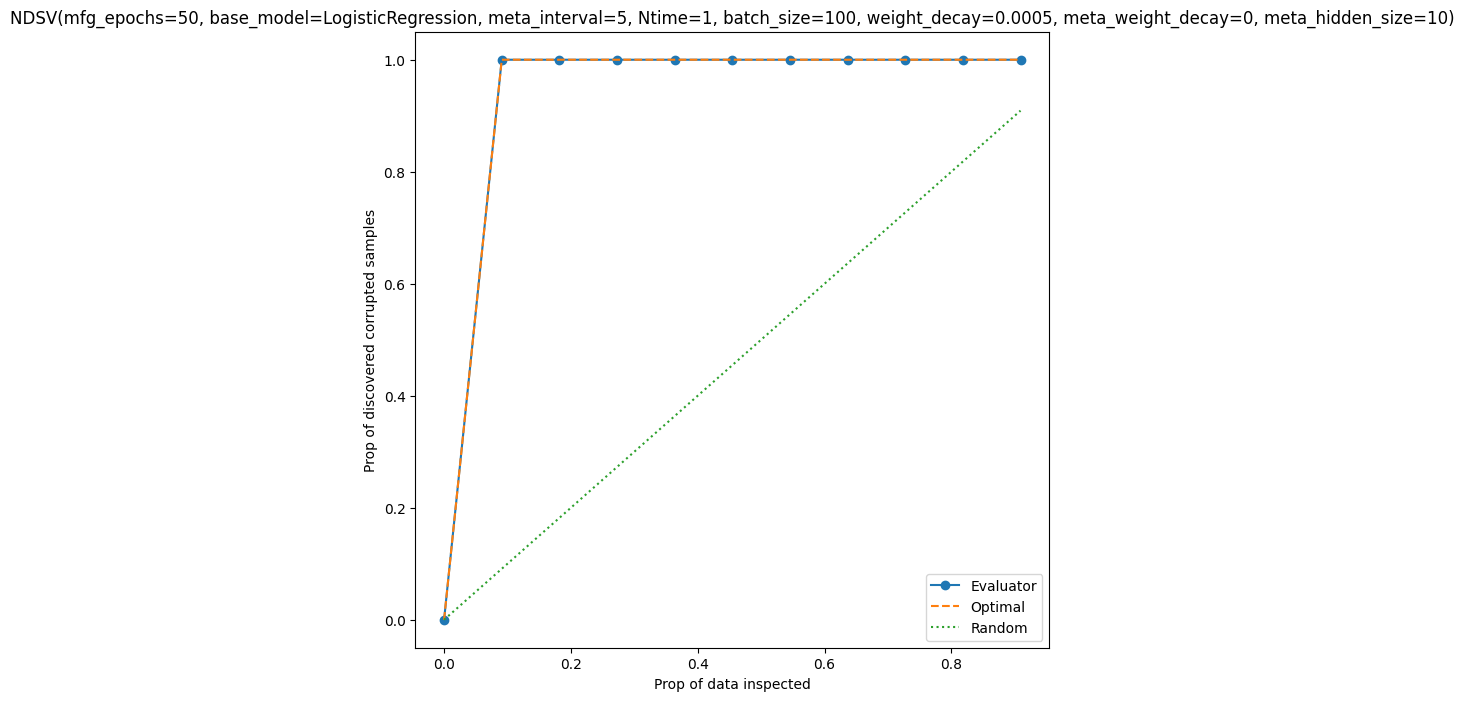

In [21]:
fig = plt.figure(figsize=(18, 8))
df, fig = exper_med.plot(discover_corrupted_sample, fig, col=2, percnet=percent, save_output=True)

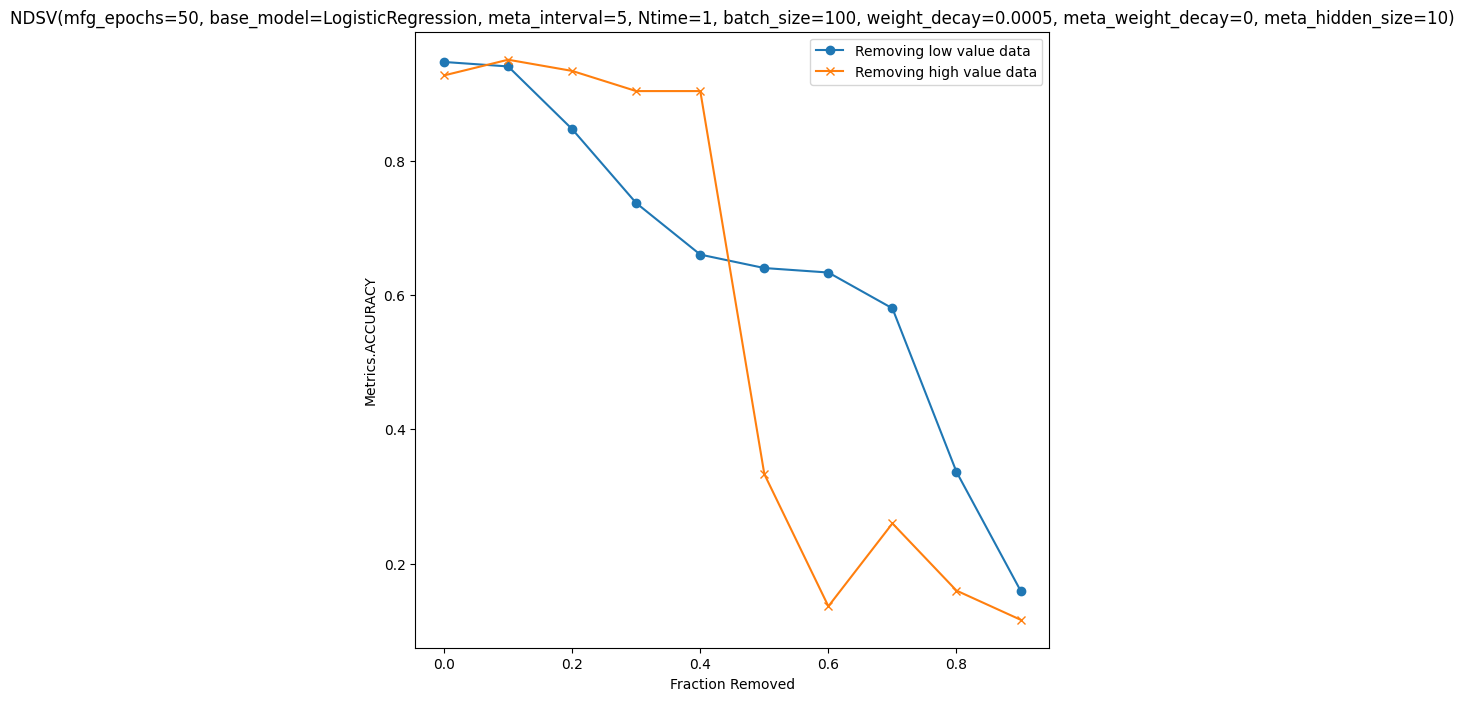

In [22]:
fig = plt.figure(figsize=(18, 8))
df_resp, fig = exper_med.plot(remove_high_low, fig, col=2, percnet=percent, save_output=True)

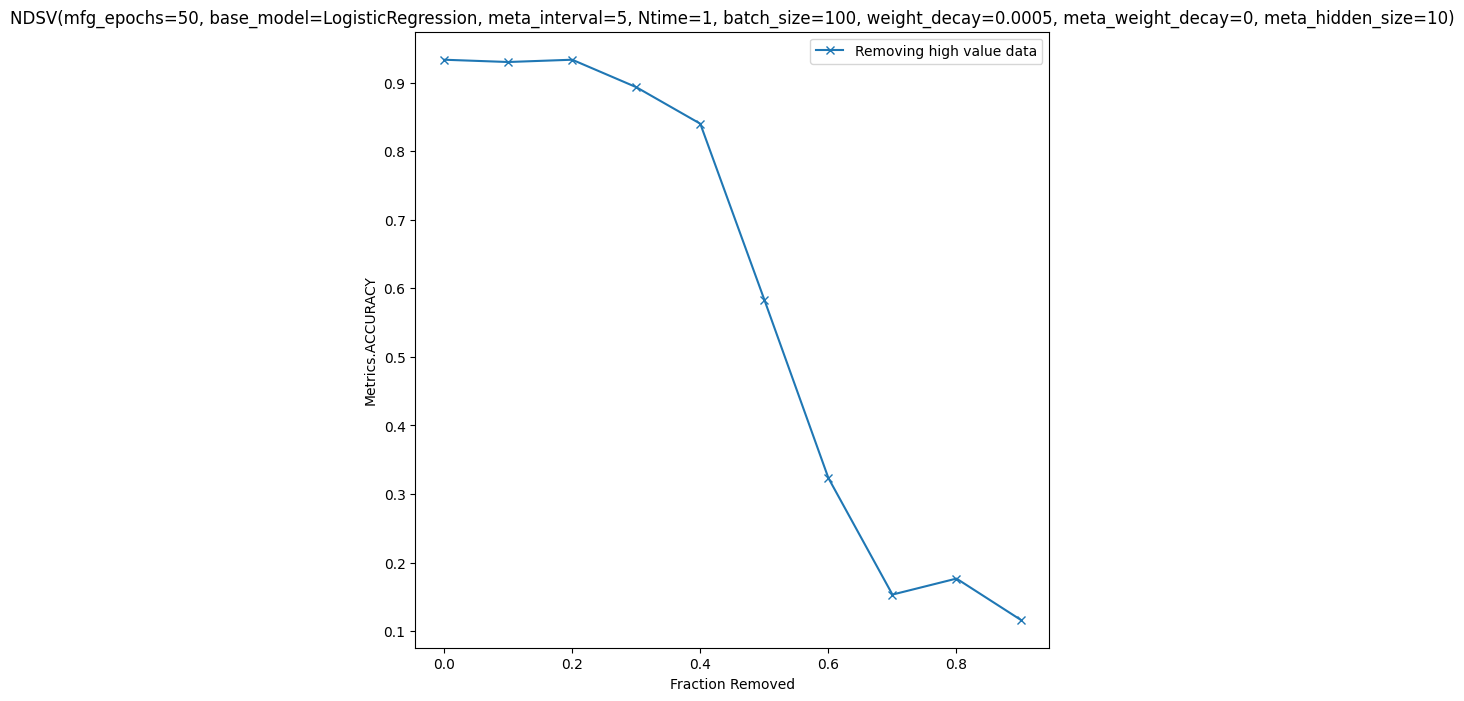

In [23]:
fig = plt.figure(figsize=(18, 8))
df, fig = exper_med.plot(remove_high_value, fig, col=2, percnet=percent, save_output=True)

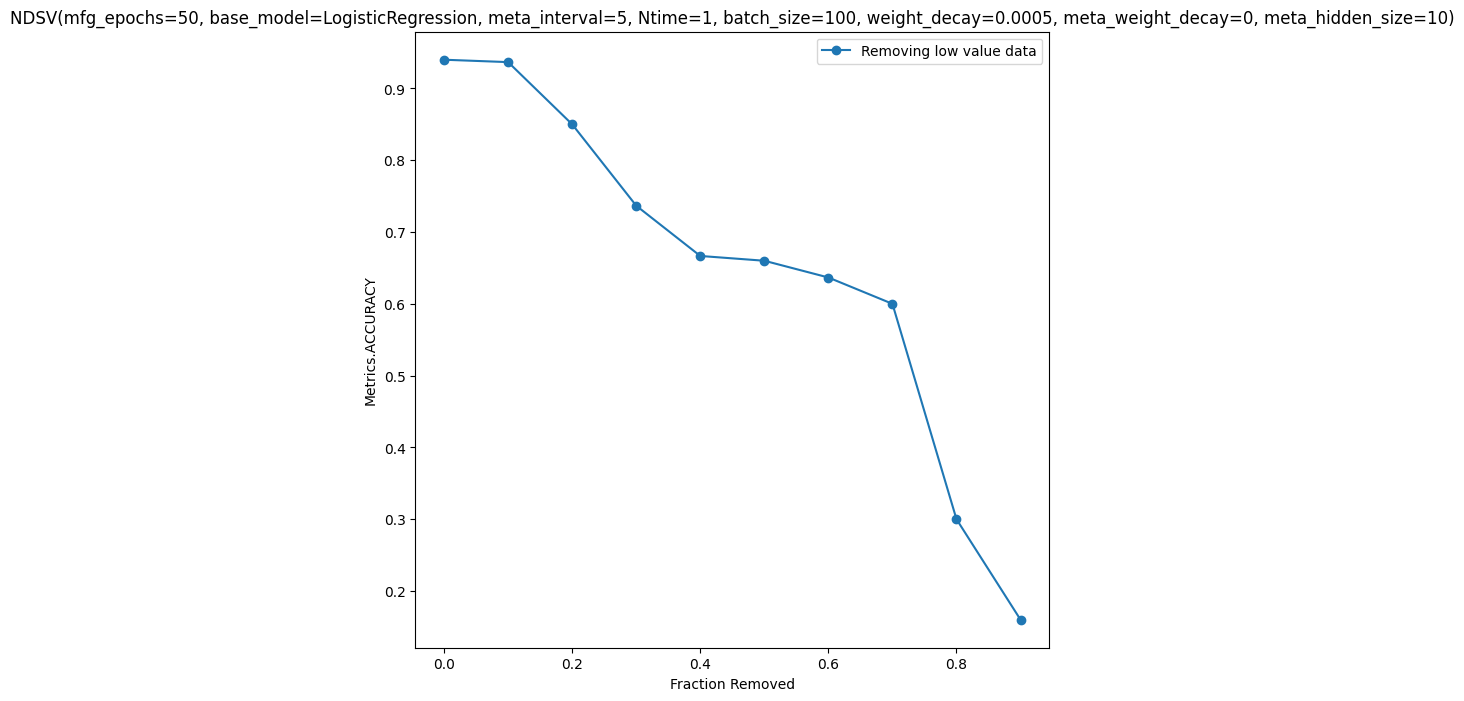

In [24]:
fig = plt.figure(figsize=(18, 8))
df, fig = exper_med.plot(remove_low_value, fig, col=2, percnet=percent, save_output=True)

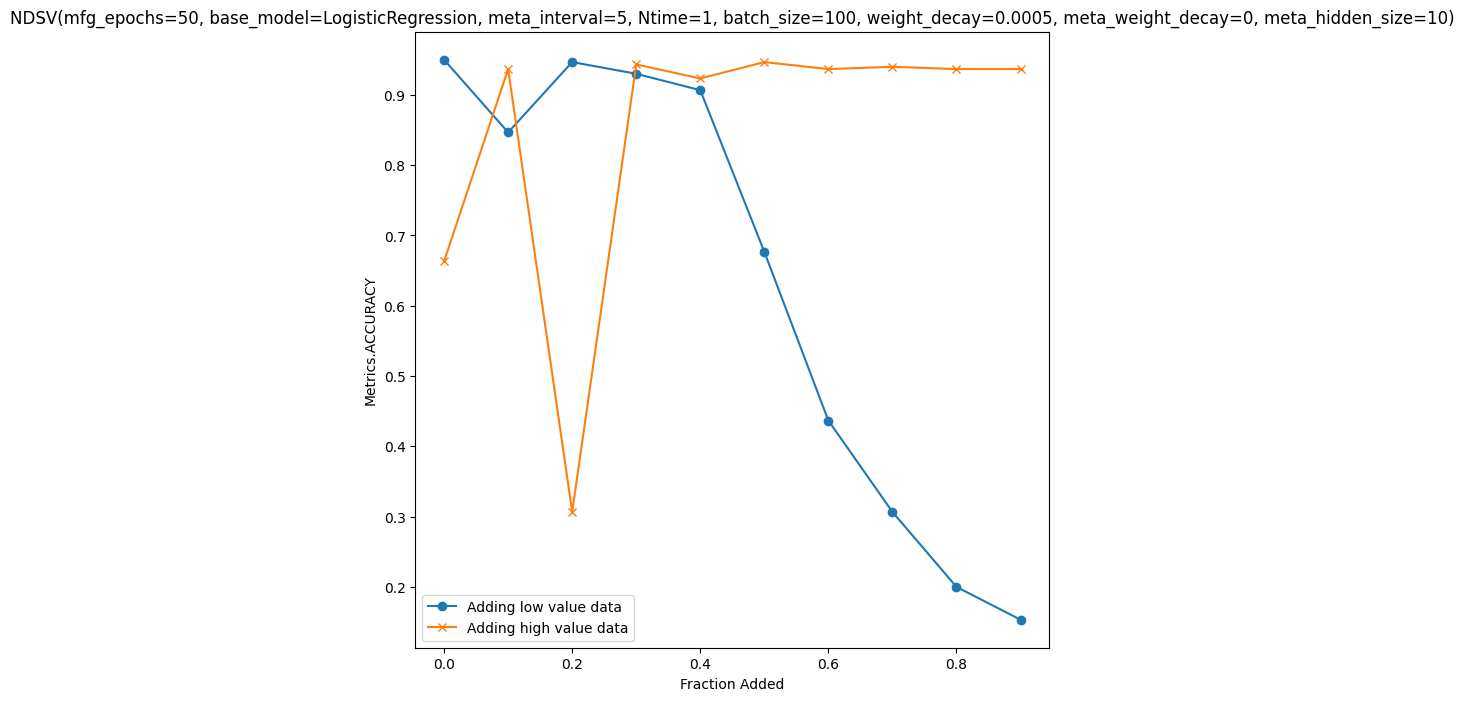

In [25]:
fig = plt.figure(figsize=(18, 8))
df_resp, fig = exper_med.plot(add_low_high, fig, col=2, percnet=percent, save_output=True)

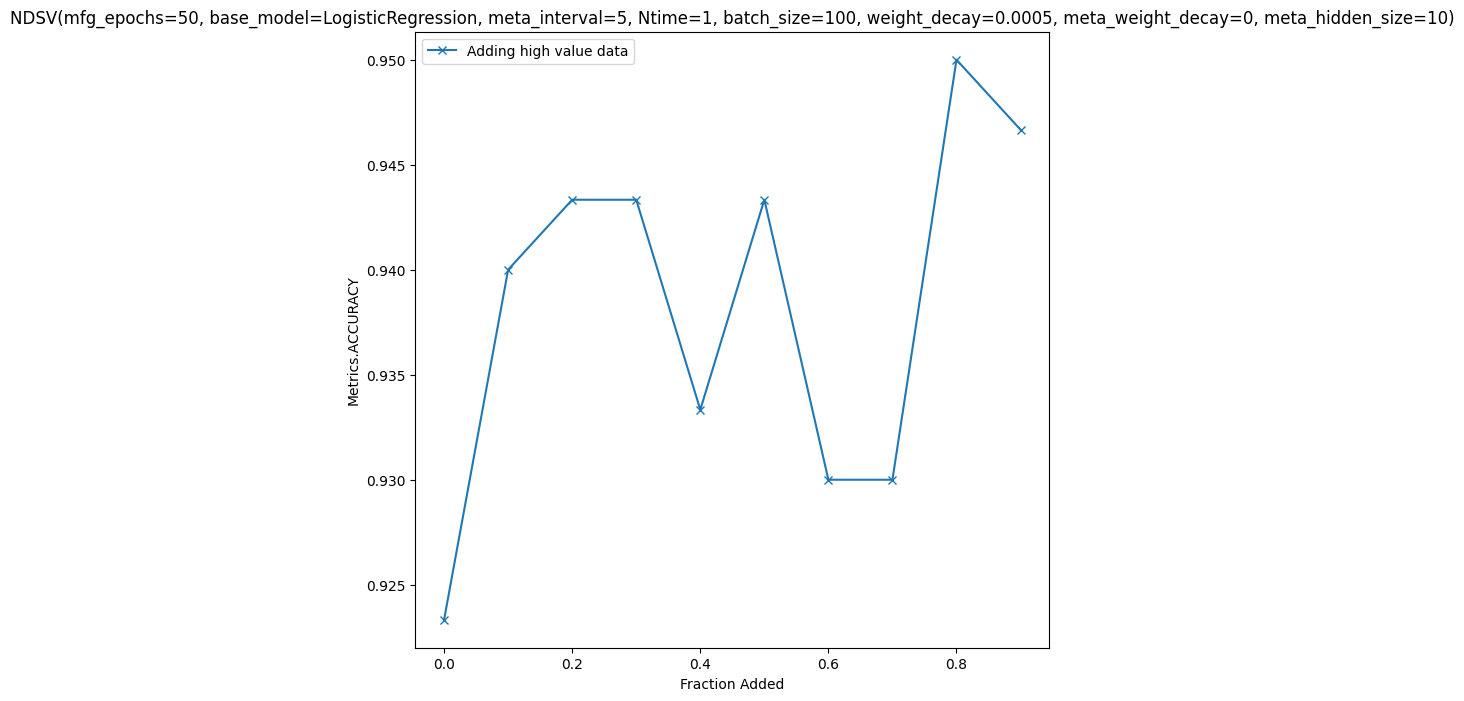

In [26]:
fig = plt.figure(figsize=(18, 8))
df, fig = exper_med.plot(add_high_value, fig, col=2, percnet=percent, save_output=True)

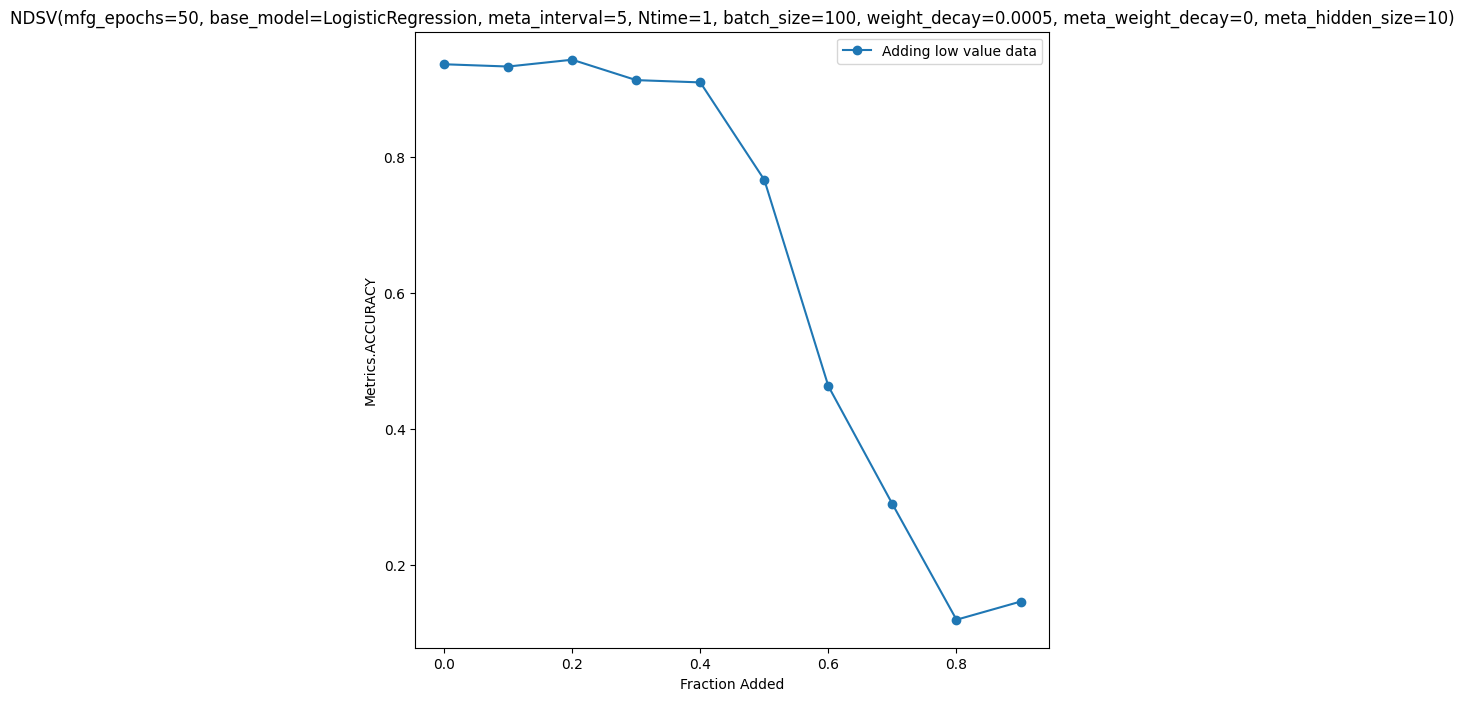

In [27]:
fig = plt.figure(figsize=(18, 8))
df, fig = exper_med.plot(add_low_value, fig, col=2, percnet=percent, save_output=True)